In [1]:
import os, json, random, cv2
import torch, torchvision

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from pycocotools.coco import COCO
import pycocotools.mask as mask_util

from tqdm import tqdm
import numpy as np

ModuleNotFoundError: No module named 'cv2'

I want to save all the annotations from the original dataset with a bounding box from mask rcnn.

Theoretically, I won't have more bounding boxes/segmentations from mask rcnn than there are on the original data.



In [2]:
# load the annotations
with open('../Downloads/gzgc.coco/annotations/instances_train2020.json') as f:
  data_train = json.load(f)
f.close()

# initialize COCO api for instance annotations
annFile='../Downloads/gzgc.coco/annotations/instances_train2020.json'
coco_train=COCO(annFile)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


Here I am passing images one at a time through the mask rcnn.

In [59]:
# data_train['annotations']

In [51]:
ann_image_ids = [data_train['images'][ann['image_id']] for ann in data_train['annotations']]



In [4]:
# initilize the configuration, pass model weights, and use the simplest predictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)


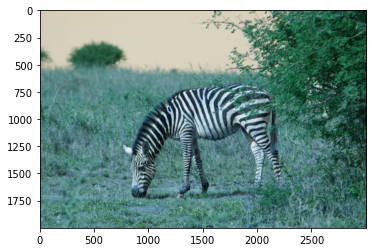

In [3]:
# load an image
im = cv2.imread("../Downloads/gzgc.coco/images/train2020/000000000072.jpg");
plt.imshow(im)

In [11]:
ann_id = 0
image_id = int(data_train['annotations'][ann_id]['image_id'] - 1)

In [63]:
data_train['annotations'][0:2]




[{'bbox': [895.5, 437.0, 1221.0, 690.0],
  'theta': 0.0,
  'viewpoint': 'left',
  'segmentation': [[896, 437, 2116, 437, 2116, 1127, 896, 1127, 896, 437]],
  'segmentation_bbox': [896, 437, 1220, 690],
  'area': 841800,
  'iscrowd': 0,
  'id': 1,
  'image_id': 1,
  'category_id': 1,
  'uuid': '7cfac6bc-379a-4859-a5c8-b21b06d2fe3d',
  'individual_ids': [2, 1, 3, 3459],
  'isinterest': 0,
  'name': 'IBEIS_PZ_1561',
  'review_ids': []},
 {'bbox': [951.0, 488.5, 1178.5, 728.5],
  'theta': 0.0,
  'viewpoint': 'left',
  'segmentation': [[951, 488, 2130, 488, 2130, 1217, 951, 1217, 951, 488]],
  'segmentation_bbox': [951, 488, 1179, 729],
  'area': 859491,
  'iscrowd': 0,
  'id': 2,
  'image_id': 2,
  'category_id': 1,
  'uuid': 'f56434d5-d829-4b56-a511-6e6c91b2f4fd',
  'individual_ids': [2, 1, 3, 3459],
  'isinterest': 0,
  'name': 'IBEIS_PZ_1561',
  'review_ids': []}]

In [64]:
data_train['images'][0:2]

[{'license': 3,
  'file_name': '000000000001.jpg',
  'photographer': "NNP GZC Car '10WHITE', Person 'A', Image 0005",
  'coco_url': None,
  'height': 2000,
  'width': 3000,
  'date_captured': '2015-03-01 14:53:46',
  'gps_lat_captured': '-1.351341',
  'gps_lon_captured': '36.800374',
  'flickr_url': None,
  'id': 1,
  'uuid': '826fb775-2f99-a8cf-7120-cba60562e82f'},
 {'license': 3,
  'file_name': '000000000002.jpg',
  'photographer': "NNP GZC Car '10WHITE', Person 'A', Image 0006",
  'coco_url': None,
  'height': 2000,
  'width': 3000,
  'date_captured': '2015-03-01 14:53:46',
  'gps_lat_captured': '-1.351341',
  'gps_lon_captured': '36.800374',
  'flickr_url': None,
  'id': 2,
  'uuid': '26a32203-4923-723c-d1fb-d0e781010ee9'}]

000000000001
[895.5, 437.0, 1221.0, 690.0]


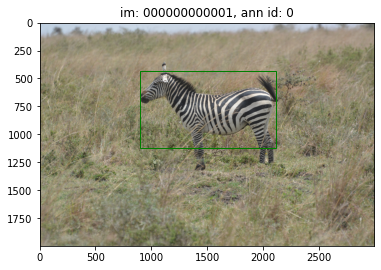

In [14]:
# show the original bounding box from annotation

file_name = data_train['images'][image_id]['file_name']
image_path = '../Downloads/gzgc.coco/images/train2020/' + file_name
im_name = os.path.basename(image_path).rstrip('.jpg')
print(im_name)
# bbox is in [tl_col, tl_row, width, height]
bbox = data_train['annotations'][ann_id]['bbox']
print(bbox)
# read image using PIL:
I = Image.open(image_path)
# convert to numpy array:
I = np.asarray(I)
f = plt.figure(figsize=(6, 5))
ax = plt.subplot()
plt.imshow(I)
ax.add_patch(Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                       linewidth=1, edgecolor='g', facecolor='none'))
ax.set_title('im: ' + im_name + ', ann id: ' + str(ann_id))
plt.show()
ann_map = {}

In [22]:
bbox_temp = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
print(bbox_temp)

[895.5, 437.0, 2116.5, 1127.0]


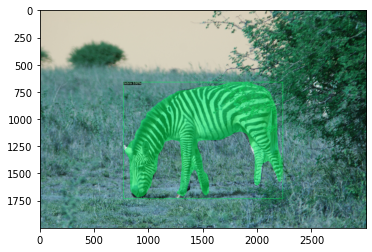

In [9]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.savefig('zebra72.jpg')

<Figure size 432x288 with 0 Axes>

In [28]:
box2 = outputs["instances"].pred_boxes.tensor.cpu().numpy()[0]
print(box2)

[ 892.2218   342.18585 2136.425   1332.939  ]


In [29]:
compute_iou(bbox_temp, box2)

0.6834519315655717

In [33]:
outputs['instances']

Instances(num_instances=1, image_height=2000, image_width=3000, fields=[pred_boxes: Boxes(tensor([[ 892.2218,  342.1859, 2136.4250, 1332.9390]])), scores: tensor([0.9995]), pred_classes: tensor([22]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])

In [148]:
len(coco_train.getImgIds())

4948

In [165]:
coco_train.getAnnIds(imgIds=[50])

[50, 51]

In [8]:
coco_train.getCatIds()

[0, 1]

In [10]:
len(coco_train.getImgIds())

4948

In [164]:
coco_train.loadAnns([50, 51])

[{'bbox': [1953.125, 851.5625, 718.75, 543.75],
  'theta': 0.0,
  'viewpoint': 'left',
  'segmentation': [[1953, 852, 2672, 852, 2672, 1395, 1953, 1395, 1953, 852]],
  'segmentation_bbox': [1953, 852, 719, 543],
  'area': 390417,
  'iscrowd': 0,
  'id': 50,
  'image_id': 50,
  'category_id': 1,
  'uuid': 'e81632b9-0d9f-44db-a9d3-09e4dc0fc33f',
  'individual_ids': [52, 50],
  'isinterest': 0,
  'name': 'IBEIS_PZ_1549',
  'review_ids': []},
 {'bbox': [1070.3125, 762.5, 885.9375, 620.3125],
  'theta': 0.0,
  'viewpoint': 'left',
  'segmentation': [[1070, 762, 1956, 762, 1956, 1383, 1070, 1383, 1070, 762]],
  'segmentation_bbox': [1070, 762, 886, 621],
  'area': 550206,
  'iscrowd': 0,
  'id': 51,
  'image_id': 50,
  'category_id': 1,
  'uuid': 'dd8f0a98-6dfb-4e9b-94e5-6de884b555bd',
  'individual_ids': [5639, 5643, 5660, 5661, 5662, 6505, 6511, 12, 53, 51],
  'isinterest': 0,
  'name': 'IBEIS_PZ_0516',
  'review_ids': []}]

In [17]:
data_train.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations', 'parts'])

In [18]:
data_train['info']

{'description': 'Wild Me GZGC-IBEIS Dataset',
 'url': 'http://www.wildme.org',
 'version': '1.0',
 'year': 2020,
 'contributor': 'Wild Me <dev@wildme.org>',
 'date_created': '2020-07-30 21:18:59.960013',
 'name': 'GZGC-IBEIS',
 'uuid': 'c03cd79d-441c-4400-bee7-38849e56fe0d'}

In [21]:
data_train['licenses']

[{'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
  'id': 3,
  'name': 'Attribution-NonCommercial-NoDerivs License'}]

In [22]:
data_train['categories']

[{'id': 0, 'name': 'giraffe_masai', 'supercategory': 'animal'},
 {'id': 1, 'name': 'zebra_plains', 'supercategory': 'animal'}]

In [71]:
data_train['annotations'][1]['test'] = 'hi'

In [72]:
data_train['annotations'][1]

{'bbox': [951.0, 488.5, 1178.5, 728.5],
 'theta': 0.0,
 'viewpoint': 'left',
 'segmentation': [[951, 488, 2130, 488, 2130, 1217, 951, 1217, 951, 488]],
 'segmentation_bbox': [951, 488, 1179, 729],
 'area': 859491,
 'iscrowd': 0,
 'id': 2,
 'image_id': 2,
 'category_id': 1,
 'uuid': 'f56434d5-d829-4b56-a511-6e6c91b2f4fd',
 'individual_ids': [2, 1, 3, 3459],
 'isinterest': 0,
 'name': 'IBEIS_PZ_1561',
 'review_ids': [],
 'test': 'hi'}

In [162]:
data_train['annotations'][49:52]

[{'bbox': [1953.125, 851.5625, 718.75, 543.75],
  'theta': 0.0,
  'viewpoint': 'left',
  'segmentation': [[1953, 852, 2672, 852, 2672, 1395, 1953, 1395, 1953, 852]],
  'segmentation_bbox': [1953, 852, 719, 543],
  'area': 390417,
  'iscrowd': 0,
  'id': 50,
  'image_id': 50,
  'category_id': 1,
  'uuid': 'e81632b9-0d9f-44db-a9d3-09e4dc0fc33f',
  'individual_ids': [52, 50],
  'isinterest': 0,
  'name': 'IBEIS_PZ_1549',
  'review_ids': []},
 {'bbox': [1070.3125, 762.5, 885.9375, 620.3125],
  'theta': 0.0,
  'viewpoint': 'left',
  'segmentation': [[1070, 762, 1956, 762, 1956, 1383, 1070, 1383, 1070, 762]],
  'segmentation_bbox': [1070, 762, 886, 621],
  'area': 550206,
  'iscrowd': 0,
  'id': 51,
  'image_id': 50,
  'category_id': 1,
  'uuid': 'dd8f0a98-6dfb-4e9b-94e5-6de884b555bd',
  'individual_ids': [5639, 5643, 5660, 5661, 5662, 6505, 6511, 12, 53, 51],
  'isinterest': 0,
  'name': 'IBEIS_PZ_0516',
  'review_ids': []},
 {'bbox': [1178.125, 878.125, 723.4375, 526.5625],
  'theta': 0.0,

In [20]:
data_train['parts']

[]

In [197]:
file_names[49]

'000000000050.jpg'

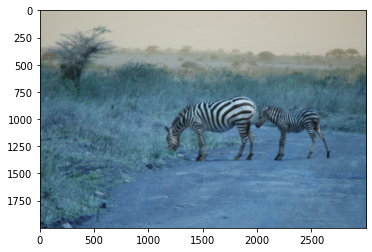

In [260]:
im = cv2.imread("../Downloads/gzgc.coco/images/train2020/000000000050.jpg");
# cv2.imshow('image', im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(im);

In [261]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [262]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

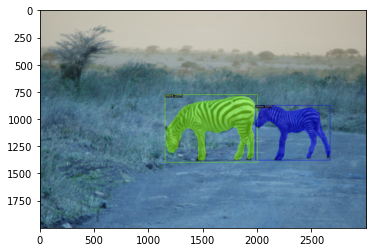

In [263]:
plt.imshow(out.get_image()[:, :, ::-1])
# plt.savefig("giraffe435.jpg")

In [39]:
instances = outputs['instances']
instances.pred_masks_rle = [mask_util.encode(np.asfortranarray(mask)) for mask in instances.pred_masks]


In [40]:
print(instances.pred_masks_rle)

[{'size': [2000, 3000], 'counts': b'hgbf1g0[m1f0@?H8G7J2M3N3M2N2N2N1O2N2O1N2N1O2O0O2N2O0O100O1O100O1O1O1O1O1O1O1O1O1O1O1N2N2O1N2N2O1N2O1O1N2O1O1O1O1O1O2N1O1O1O1O100O1O1O100O1O1O010O001O001O1O0O2O000O2O0O2N100O101N1O100O1O1O1O100O1O1O2O0000001O001O00010O001O010O10O0100O1O010O1O1O10O01O1O1O1O001O1N2O1O0O2N2O1N1O2O1N2O1O0O2O1O1O1O00100O1O1O010O1O100O00100O100O00100O1O1O001O1O1O001O1N2L3M4L4L4L3L5L4K5D;F;F:L3O2O1N101O1N101O1O001O1O010O001O100000100O1O00100O001O10O01O1O010O1O0010O01O1O010O001O010O001O010O0010O01O0010O01O010O001O0100O1000000O10001O1O1O1O10010O0010O010000000O1O1N2N100O00001O000O1000000O01000O10O010O0100O0100O0100O01000O100000000000001O001O100O1O1O1O1O1N101O001N101O0O101O0O100O100O1O100O100O1O00100O1O1O100O1O2O0O1O2O0O2N2O1N2N2O1N3N2M4L4M4K3N3L3N2M3N2M3N0O100O2O000O1000O0100000O010000O1000O0100O2O000O101N101N101N2O1N2O1N2O1N2O0O2O1N1O101N100O1O2O0O100O1O100O00100O100O100O10000O10000O2O00001O001O1O010O1O100O2N1O1O3M3M3M2N2N2M3N2N2N1N2O1O1N2O1O0O2O0O101O0O10001N101O1O001O1O1O1O2

In [41]:
for rle in instances.pred_masks_rle:
    rle['counts'] = rle['counts'].decode('utf-8')

In [44]:
instances.remove('pred_masks')

In [48]:
instances.pred_masks = np.stack([mask_util.decode(rle) for rle in instances.pred_masks_rle])

In [68]:
for rle in instances.pred_masks_rle:
    print(rle)
    print(mask_util.decode(rle))

{'size': [2000, 3000], 'counts': 'hgbf1g0[m1f0@?H8G7J2M3N3M2N2N2N1O2N2O1N2N1O2O0O2N2O0O100O1O100O1O1O1O1O1O1O1O1O1O1O1N2N2O1N2N2O1N2O1O1N2O1O1O1O1O1O2N1O1O1O1O100O1O1O100O1O1O010O001O001O1O0O2O000O2O0O2N100O101N1O100O1O1O1O100O1O1O2O0000001O001O00010O001O010O10O0100O1O010O1O1O10O01O1O1O1O001O1N2O1O0O2N2O1N1O2O1N2O1O0O2O1O1O1O00100O1O1O010O1O100O00100O100O00100O1O1O001O1O1O001O1N2L3M4L4L4L3L5L4K5D;F;F:L3O2O1N101O1N101O1O001O1O010O001O100000100O1O00100O001O10O01O1O010O1O0010O01O1O010O001O010O001O010O0010O01O0010O01O010O001O0100O1000000O10001O1O1O1O10010O0010O010000000O1O1N2N100O00001O000O1000000O01000O10O010O0100O0100O0100O01000O100000000000001O001O100O1O1O1O1O1N101O001N101O0O101O0O100O100O1O100O100O1O00100O1O1O100O1O2O0O1O2O0O2N2O1N2N2O1N3N2M4L4M4K3N3L3N2M3N2M3N0O100O2O000O1000O0100000O010000O1000O0100O2O000O101N101N101N2O1N2O1N2O1N2O0O2O1N1O101N100O1O2O0O100O1O100O00100O100O100O10000O10000O2O00001O001O1O010O1O100O2N1O1O3M3M3M2N2N2M3N2N2N1N2O1O1N2O1O0O2O0O101O0O10001N101O1O001O1O1O1O2N3

In [269]:
outputs["instances"].pred_masks.numpy()

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

https://github.com/facebookresearch/detectron2/issues/984

In [252]:
outputs["instances"]

Instances(num_instances=1, image_height=2000, image_width=3000, fields=[pred_boxes: Boxes(tensor([[ 751.4367,  558.2872, 2047.1035, 1790.6572]])), scores: tensor([0.9994]), pred_classes: tensor([23]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])

In [238]:
outputs["instances"].pred_boxes.tensor.cpu().numpy()

array([[1147.1967 ,  775.32806, 1994.7922 , 1396.0225 ],
       [1974.6094 ,  874.10767, 2661.0122 , 1377.0603 ]], dtype=float32)

In [301]:
outputs["instances"].pred_masks

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [75]:
predictor.metadata.thing_classes[22]

'zebra'

In [76]:
print(outputs["instances"].pred_classes)

tensor([22, 22, 22])


In [77]:
print(outputs["instances"].pred_boxes)

Boxes(tensor([[  41.7822,  782.6675, 1330.5405, 1620.9911],
        [1125.8760,  841.7449, 2004.7681, 1683.6176],
        [2294.0911, 1393.9362, 2995.3391, 1984.3451]]))


In [79]:
type(outputs["instances"].pred_boxes)

detectron2.structures.boxes.Boxes

In [89]:
outputs["instances"].pred_boxes.tensor[0].cpu().numpy()

array([  41.782227,  782.66754 , 1330.5405  , 1620.9911  ], dtype=float32)

In [47]:
v

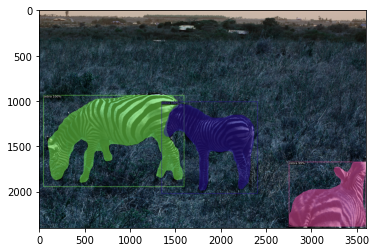

In [32]:
os.path.isfile('../Downloads/detectron2/demo/demo.py')

True

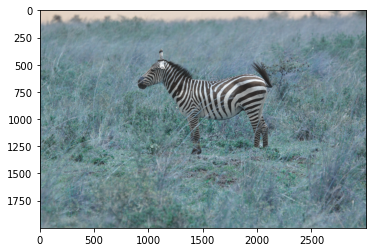

In [19]:
def compute_iou(box_1, box_2):
    '''
    This function takes a pair of bounding boxes and returns intersection-over-
    union (IoU) of two bounding boxes.
    '''
#     iou = np.random.random()

    # separate out coordinate so it's easier for me to think about
    box1_tl_row, box1_tl_col, box1_br_row, box1_br_col = box_1
    box2_tl_row, box2_tl_col, box2_br_row, box2_br_col = box_2
    
    # calculate the intersection coordinates
    tl_row_i = max(box1_tl_row, box2_tl_row)
    tl_col_i = max(box1_tl_col, box2_tl_col)
    br_row_i = min(box1_br_row, box2_br_row)
    br_col_i = min(box1_br_col, box2_br_col)
    
    # calulate dimensions of intersection box
    intersect_height = br_col_i - tl_col_i 
    intersect_width = br_row_i - tl_row_i
    
    # see if there is intersection between two boxes
    if (tl_row_i >= br_row_i) or (tl_col_i >= br_col_i):
        intersection_area = 0
    else:
        intersection_area = intersect_height * intersect_width
    
    # calculate area of both boxes
    box1_height = box1_br_col - box1_tl_col
    box1_width = box1_br_row - box1_tl_row
    box1_area = box1_height * box1_width
    
    box2_height = box2_br_col - box2_tl_col
    box2_width = box2_br_row - box2_tl_row
    box2_area = box2_height * box2_width
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    
    assert (iou >= 0) and (iou <= 1.0)

    return iou

Get bounding boxes from Mask-RCNN. Obtain the bounding boxes that overlap best with the ones provided in the WildMe dataset.

In [270]:
# need a list of the image file names
data_path = '../Downloads/gzgc.coco/images/train2020/'
file_names = sorted(os.listdir(data_path))
file_names = [f for f in file_names if '.jpg' in f] # 4948 images

image_id_bbox = {}
image_id_mask = {}

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

for file in tqdm(file_names):
    # get the 'ground truth' bounding box(es)
    imgID = file_name_to_id[file]
    annIDs = coco_train.getAnnIds(imgIds = imgID)
    bbox_list = [ann['bbox'] for ann in coco_train.loadAnns(annIDs)]
    # convert from [x1, y1, width, height] to [x1, y1, x2, y2] where (x1, y1) is top-left corner
    bbox_list_tlbr = [[box[0], box[1], box[0]+box[2], box[1]+box[3]] for box in bbox_list]
#     print(bbox_list_tlbr)
    
    # get the mask rcnn bounding boxes
    im = cv2.imread(f"../Downloads/gzgc.coco/images/train2020/{file}");
    outputs = predictor(im)
    bbox_list2 = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    mask_list = outputs["instances"].pred_masks.numpy()
#     print(bbox_list2)
    
    bbox_list_final = []
    mask_list_final = []
    
    for box1 in bbox_list2:
        for i, box2 in enumerate(bbox_list_tlbr):
            iou = compute_iou(box1, box2)
#             print(box1, box2, iou)
            if iou > 0.75:
                bbox_list_final.append(box1)
                mask_list_final.append(mask_list[i])
                
    image_id_bbox[imgID] = bbox_list_final
    image_id_mask[imgID] = mask_list_final

100%|██████████| 4948/4948 [8:57:41<00:00,  6.52s/it]  


In [275]:
np.save("image_id_bbox.npy", image_id_bbox)

In [276]:
np.save("image_id_mask.npy", image_id_mask)

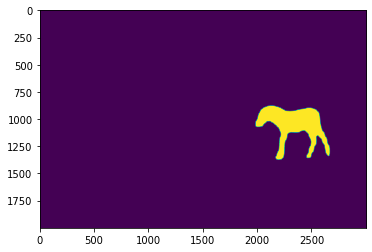

In [293]:
plt.imshow(image_id_mask[50][0])

In [3]:
# image_id_mask

In [277]:
import pickle

In [278]:
f = open("image_id_mask.pkl","wb")
pickle.dump(image_id_mask,f)
f.close()

KeyboardInterrupt: 

In [ ]:
f = open("image_id_bbox.pkl","wb")
pickle.dump(image_id_bbox,f)
f.close()

In [271]:
json1 = json.dumps(image_id_bbox)
f = open("image_id_bbox.json","w")
f.write(json1)
f.close()


json2 = json.dumps(image_id_mask)
f = open("image_id_mask.json","w")
f.write(json2)
f.close()

TypeError: Object of type ndarray is not JSON serializable

In [240]:
print(bbox_list_final)

[array([1147.1967 ,  775.32806, 1994.7922 , 1396.0225 ], dtype=float32), array([1974.6094 ,  874.10767, 2661.0122 , 1377.0603 ], dtype=float32)]


In [221]:
bbox_list2 = outputs["instances"].pred_boxes.tensor.cpu().tolist()

In [ ]:
compute_iou(bbox_list, bbox_list2)

In [ ]:
outputs["instances"].pred_boxes.tensor[0].cpu().numpy()

In [222]:
bbox_list2

[[1147.1966552734375, 775.3280639648438, 1994.792236328125, 1396.0224609375],
 [1974.609375, 874.107666015625, 2661.01220703125, 1377.060302734375]]

In [102]:
data_train['images'][0]

{'license': 3,
 'file_name': '000000000001.jpg',
 'photographer': "NNP GZC Car '10WHITE', Person 'A', Image 0005",
 'coco_url': None,
 'height': 2000,
 'width': 3000,
 'date_captured': '2015-03-01 14:53:46',
 'gps_lat_captured': '-1.351341',
 'gps_lon_captured': '36.800374',
 'flickr_url': None,
 'id': 1,
 'uuid': '826fb775-2f99-a8cf-7120-cba60562e82f'}

In [112]:
file_name_to_id = dict([[i['file_name'], i['id']] for i in data_train['images']])

In [115]:
file_name_to_id[file_names[0]]

1

In [170]:
file_names[50]

'000000000051.jpg'

In [190]:
bboxes = bbox_list

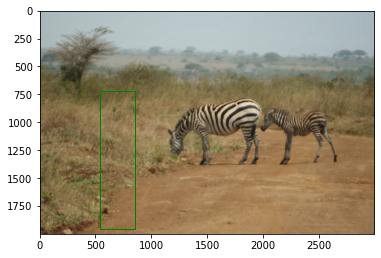

In [192]:
image = Image.open(f"../Downloads/gzgc.coco/images/train2020/{file_names[49]}")
f = plt.figure(figsize=(6, 5))
ax = plt.subplot()
plt.imshow(image)
ax.add_patch(Rectangle((bboxes[0][1], bboxes[0][0]),
                        bboxes[0][3]- bboxes[0][1], bboxes[0][2]- bboxes[0][0],
                       linewidth=1, edgecolor='g', facecolor='none'))
plt.show()

In [10]:
# load the annotations
with open('../Downloads/gzgc.coco/annotations/instances_train2020_maskrcnn.json') as f:
  data_train2 = json.load(f)
f.close()

In [76]:
data_train2.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations', 'parts'])

In [14]:
data_train2['annotations'][73]

{'bbox': [796.875, 650.0, 1426.5625, 1082.8125],
 'theta': 0.0,
 'viewpoint': 'left',
 'segmentation': [[797, 650, 2223, 650, 2223, 1733, 797, 1733, 797, 650]],
 'segmentation_bbox': [797, 650, 1426, 1083],
 'area': 1544358,
 'iscrowd': 0,
 'id': 74,
 'image_id': 72,
 'category_id': 1,
 'uuid': 'af45e34f-3c65-4b0e-acd9-0f97673968fe',
 'individual_ids': [2678, 74, 240],
 'isinterest': 0,
 'name': 'IBEIS_PZ_0017',
 'review_ids': [],
 'bbox_tlbr': [796.875, 650.0, 2223.4375, 1732.8125],
 'maskrcnn_bbox': [766.3842163085938,
  660.9681396484375,
  2227.41162109375,
  1729.6124267578125],
 'maskrcnn_mask_rle': {'size': [2000, 3000],
  'counts': 'Yi`_13[n15L3L5K4M3L4M3L4M2N3M3L3N3M2N3M2N2N3M2M4M3M2M3N3L3M4M3L3N3L4M3L4L4M3L4M4K4L5L3L6J:F:G:E:mWNUKoe1i7lN>C<Cf0ZOk0VO]2bM6K5K4L4L4L4M3L4L3M3N3L3M2O1N2N2O1N2O1N1O2N2O1N2N2N2N1O2N2N2N2N2N2N2M3N2M2O2M3K5I7I7I7I7I7I7L4M3L4L4M3M3M3M3M3M2O2M2N3N2M2O2N1N3N1O2N1O2N10O01O1O1O1O0O2O1O1O0O2O1N2O0O2N2O1N1O2M3N1O2M3J6K4K6K5K4L5K5M201O1N101O1O001O1O001O10O01O1

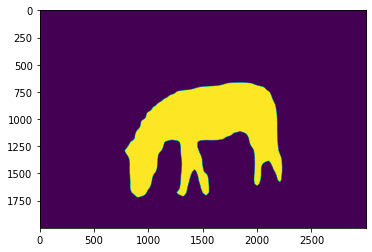

In [17]:
plt.imshow(mask_util.decode(data_train2['annotations'][73]['maskrcnn_mask_rle']))

In [35]:
image = Image.open(f"../Downloads/gzgc.coco/images/train2020/000000000072.jpg")
mask = mask_util.decode(data_train2['annotations'][73]['maskrcnn_mask_rle'])
segImage = image.copy()
segImage  = np.array(segImage)
binaryMask = (mask > 0.5).astype(np.float32)
segImage[np.where(binaryMask == 0.0)] = 0
image = Image.fromarray(np.uint8(segImage)).convert('RGB')


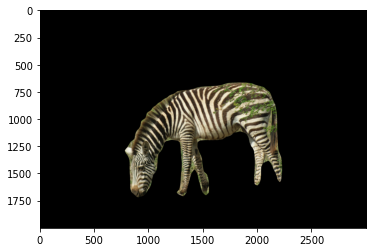

In [20]:
plt.imshow(image)
plt.savefig('zebra72_seg.jpg')

In [25]:
def crop_to_bbox(image: Image.Image, bbox: tuple):
        # Assume order of bbox from maskrcnn
        x_left, y_top, x_right, y_bottom = bbox
        width = x_right - x_left
        height = y_bottom - y_top
        x_center = (x_left + x_right) / 2
        y_center = (y_top + y_bottom) / 2

        # Crop to a square box, so this doesn't get cut off later
        new_size = max(width, height)
        x_left = round(x_center - (new_size / 2))
        y_top = round(y_center - (new_size / 2))

        cropped_image = torchvision.transforms.functional.crop(image, y_top, x_left, new_size, new_size)

        return cropped_image

In [36]:
# image = Image.open(f"../Downloads/gzgc.coco/images/train2020/000000000072.jpg")
bbox = data_train2['annotations'][73]['maskrcnn_bbox']

In [38]:
image = crop_to_bbox(image, bbox)

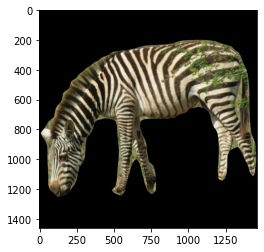

In [39]:
plt.imshow(image)
plt.savefig('zebra72_seg_crop.jpg')

In [42]:
image = Image.open(f"../Downloads/gzgc.coco/images/train2020/000000000072.jpg")
bbox_tlbr = data_train2['annotations'][73]['maskrcnn_bbox']
# bbox_tlbr = annotation['bbox']
x_tl, y_tl, x_br, y_br = bbox_tlbr
# Round partial pixels as necessary
x_tl = int(np.floor(x_tl))
y_tl = int(np.floor(y_tl))
x_br = int(np.ceil(x_br))
y_br = int(np.ceil(y_br))

image_arr = np.array(image)

# Zero out outside the bounding boxes
image_arr[:y_tl,:,:] = 0
image_arr[:,:x_tl,:] = 0
image_arr[y_br:,:,:] = 0
image_arr[:,x_br:,:] = 0

image = Image.fromarray(np.uint8(image_arr)).convert('RGB')

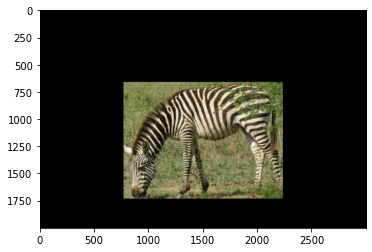

In [43]:
plt.imshow(image)
plt.savefig('zebra72_bbox.jpg')

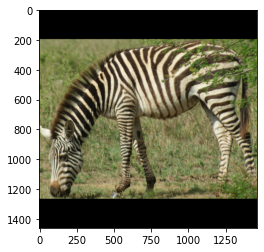

In [44]:
image = crop_to_bbox(image, bbox)
plt.imshow(image)
plt.savefig('zebra72_bbox_crop.jpg')

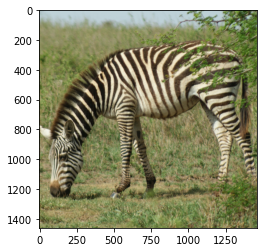

In [45]:
image = Image.open(f"../Downloads/gzgc.coco/images/train2020/000000000072.jpg")
bbox_tlbr = data_train2['annotations'][73]['maskrcnn_bbox']

image = crop_to_bbox(image, bbox_tlbr)
plt.imshow(image)
plt.savefig('zebra72_bbox_crop.jpg')